# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.500120,True,10.041553
1,-0.118717,False,-0.653754
2,2.343310,True,11.389837
3,1.135515,True,7.366952
4,2.129092,True,10.446560
...,...,...,...
995,0.350446,True,5.850539
996,0.341666,True,5.968433
997,1.815889,True,9.846250
998,-0.068380,False,-0.571391


<AxesSubplot: xlabel='v0'>

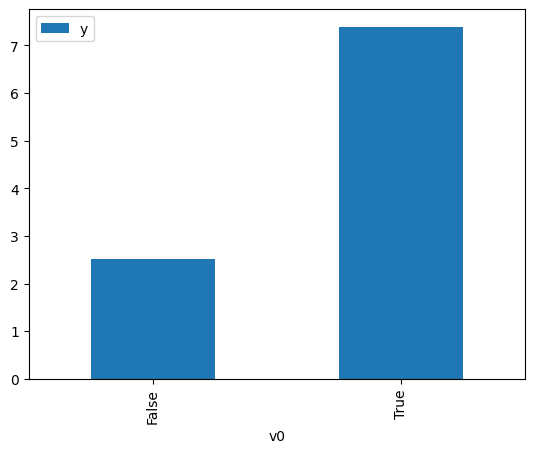

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

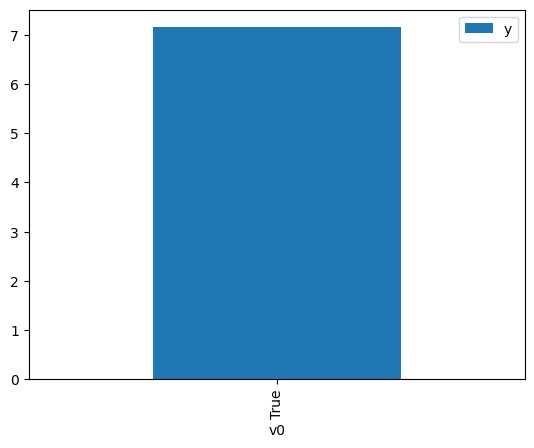

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.993156,False,3.330883,0.085857,11.647240
1,0.499243,False,2.058364,0.216151,4.626404
2,-0.019544,False,-0.232769,0.460844,2.169930
3,2.185475,False,5.012801,0.006927,144.358079
4,-0.267621,False,-0.243164,0.594845,1.681111
...,...,...,...,...,...
995,2.185475,False,5.012801,0.006927,144.358079
996,1.134589,False,2.298029,0.064542,15.493755
997,1.118091,False,2.022158,0.066749,14.981580
998,1.396144,False,4.069666,0.037540,26.638149


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.375325,True,10.427390,0.995410,1.004611
1,0.883296,True,6.318338,0.893379,1.119345
2,2.616817,True,9.532702,0.997284,1.002723
3,0.885098,True,6.815578,0.893753,1.118877
4,1.151974,True,7.205769,0.937709,1.066428
...,...,...,...,...,...
995,3.272957,True,11.762225,0.999349,1.000651
996,0.681270,True,8.159526,0.843590,1.185411
997,-0.162901,True,6.143601,0.461161,2.168440
998,-0.200227,True,4.235495,0.441010,2.267524


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          2.571e+04
Date:                Wed, 18 Jan 2023   Prob (F-statistic):                        0.00
Time:                        14:08:55   Log-Likelihood:                         -1415.3
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2403      0.037     59.877      0.000       2.167       2.314
x2             5.0384      0.058     86.870      0.000       4.925       5.152
==============================================================================
Omnibus:                        1.714   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.650
Skew:                          -0.099   Prob(JB):                        0.438
Kurtosis:                       3.024   Cond. No.                         3.27
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""